In [2]:
import numpy as np
import pandas as pd

In [3]:
import os
print(os.listdir("input"))

['Consumer_Complaints.csv']


In [4]:
import pandas as pd
df = pd.read_csv('input/Consumer_Complaints.csv')

In [5]:
np.random.seed(10)
remove_n = 1000000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)
df.shape
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
10,04/14/2017,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",CA,90305,NaN,NaN,Referral,04/14/2017,Closed with explanation,Yes,No,2436165,NaN
19,03-09-2016,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,92703,NaN,NaN,Phone,03-09-2016,Closed with explanation,Yes,No,1823789,NaN
21,03/17/2017,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,NaN,Company believes it acted appropriately as aut...,UNITED SERVICES AUTOMOBILE ASSOCIATION,WI,54005,NaN,NaN,Referral,03/20/2017,Closed with explanation,Yes,No,2393048,NaN
24,02/25/2014,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,NaN,NaN,"Navient Solutions, LLC.",RI,2906,NaN,NaN,Web,02/24/2014,Closed with explanation,Yes,Yes,730165,NaN
88,04/18/2017,Student loan,Non-federal student loan,Can't repay my loan,Can't decrease my monthly payments,NaN,NaN,JPMORGAN CHASE & CO.,MD,20772,NaN,NaN,Referral,04/19/2017,Closed with explanation,Yes,No,2439594,NaN


In [6]:
from io import StringIO
col = ['Product', 'Consumer Complaint']
df = df[col]
df = df[pd.notnull(df['Consumer Complaint'])]
df.columns = ['Product', 'Consumer_Complaint']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_Complaint,category_id
947,Debt collection,Called XXXX verified they sent me a letter ver...,0
1009,Credit reporting,A original debt when into collections from XXX...,1
1209,Bank account or service,XX/XX/XXXX I received a confirmation of addres...,2
1244,Credit card,I received an application for the American Exp...,3
1268,Credit reporting,There is an account listed from XXXX XXXX XXXX...,1


In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_Complaint.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_Complaint).toarray()
labels = df.category_id
features.shape

(6769, 19329)

In [9]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("--> '{}':".format(Product))
  print("  . Most Correlated Unigrams are :\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most Correlated Bigrams are :\n. {}".format('\n. '.join(bigrams[-N:])))

--> 'Bank account or service':
  . Most Correlated Unigrams are :
. bank
. overdraft
  . Most Correlated Bigrams are :
. checking account
. overdraft fees
--> 'Checking or savings account':
  . Most Correlated Unigrams are :
. bonus
. deposit
  . Most Correlated Bigrams are :
. checking account
. 00 bonus
--> 'Consumer Loan':
  . Most Correlated Unigrams are :
. car
. vehicle
  . Most Correlated Bigrams are :
. hyundai motor
. purchased vehicle
--> 'Credit card':
  . Most Correlated Unigrams are :
. macy
. card
  . Most Correlated Bigrams are :
. american express
. credit card
--> 'Credit card or prepaid card':
  . Most Correlated Unigrams are :
. rewards
. card
  . Most Correlated Bigrams are :
. credit card
. cash advances
--> 'Credit reporting':
  . Most Correlated Unigrams are :
. equifax
. experian
  . Most Correlated Bigrams are :
. credit file
. credit report
--> 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most Correlated Unigrams are :
. 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_Complaint'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [11]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [12]:
df[df['Consumer_Complaint'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_Complaint,category_id


In [13]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Debt collection']


In [14]:
df[df['Consumer_Complaint'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,Product,Consumer_Complaint,category_id


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The mi

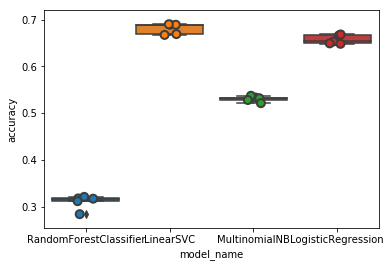

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.680763
LogisticRegression        0.656955
MultinomialNB             0.530497
RandomForestClassifier    0.310822
Name: accuracy, dtype: float64

In [17]:
model = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_Complaint'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf1=model.fit(X_train_tfidf, y_train)

In [19]:
print(clf1.predict(count_vect.transform(["request for new account"])))

['Mortgage']


In [44]:
print(clf1.predict(count_vect.transform(["I lost my credit card"])))

['Credit card']


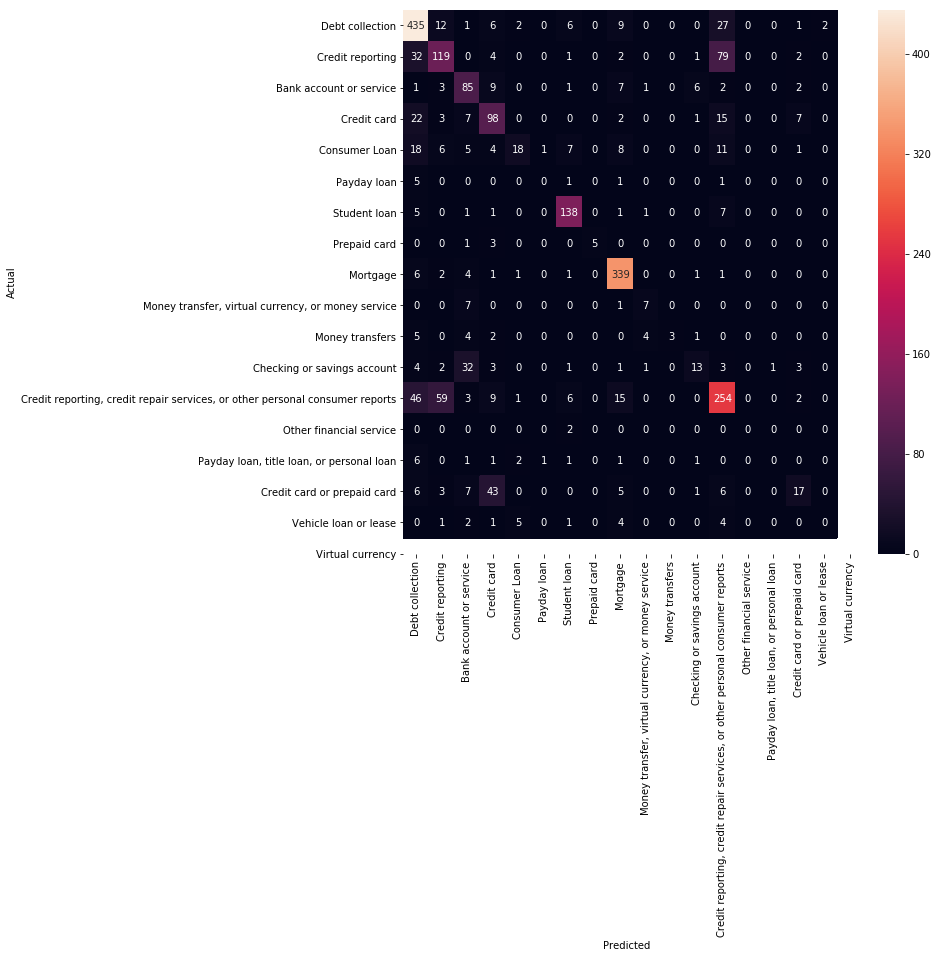

In [46]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [47]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_Complaint']])
      print('')

'Credit reporting' predicted as 'Debt collection' : 32 examples.


,Product,Consumer_Complaint
776215,Credit reporting,I have recently pulled out my credit profile f...
509157,Credit reporting,I am not a 100 % sure. But if credit can only ...
757636,Credit reporting,I received an email from XXXX XXXX on XX/XX/XX...
733315,Credit reporting,"I filed a dispute on XXXX XXXX, 2015. I reques..."
549517,Credit reporting,I never received any documentation other than ...
441521,Credit reporting,There are XXXX accounts on my credit report th...
198245,Credit reporting,I have submitted several request disputing col...
607170,Credit reporting,Trans Union offered me a credit monitoring pro...
564252,Credit reporting,XXXX Reported I owed XXXX XXXX an apartment co...
651780,Credit reporting,I was in a 6 month lease and during the last m...



'Credit card' predicted as 'Debt collection' : 22 examples.


,Product,Consumer_Complaint
558796,Credit card,. For the past 2 months I have been receiving ...
522704,Credit card,I received a bill from Citicard XXXX for a Cos...
244882,Credit card,I have submitted documents required of me from...
425031,Credit card,On XXXX XXXX I started getting emails from Cap...
747973,Credit card,Constant calls concerning credit account which...
731049,Credit card,I filed an complaint with Barclays bank of XXX...
616485,Credit card,I would like your assistance in obtain feedbac...
602054,Credit card,We field a prior complaint with CPFB regarding...
651807,Credit card,I keep getting calls XXXX. There have been 7 c...
778745,Credit card,I am a US citizen and was interested in buying...



'Consumer Loan' predicted as 'Debt collection' : 18 examples.


,Product,Consumer_Complaint
180973,Consumer Loan,NONE of the above ... It 's not our credit iss...
253106,Consumer Loan,On XX/XX/XXXX I formally communicated to Prest...
867840,Consumer Loan,While XXXX on XXXX XXXX due to a complicated X...
296852,Consumer Loan,"XX/XX/XXXX, I purchased a XXXX Dodge Intrepid...."
485865,Consumer Loan,I had a repossession back in early XX/XX/XXXX ...
484804,Consumer Loan,I co-signed a loan for my daughter for a car. ...
96860,Consumer Loan,the company Westlake financial doing business ...
751390,Consumer Loan,My vehicle was repossessed in XX/XX/XXXX. A co...
1950,Consumer Loan,ALLY Financial assessed Excess Wear on XXXX Ch...
527571,Consumer Loan,Ace cash express sent me email correspondence ...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 46 examples.


,Product,Consumer_Complaint
840679,"Credit reporting, credit repair services, or o...",I moved several times and was not getting my s...
943826,"Credit reporting, credit repair services, or o...",XXXX XXXX had recently filed a judgement again...
1019300,"Credit reporting, credit repair services, or o...",I am writing a complaint after being harassed ...
803419,"Credit reporting, credit repair services, or o...","Best Buy, who uses Citicard sent a letter con..."
935290,"Credit reporting, credit repair services, or o...",The company is reporting the incorrect balance...
999387,"Credit reporting, credit repair services, or o...",Original Creditor : XXXX XXXX XXXX XXXX XXXX X...
920958,"Credit reporting, credit repair services, or o...",I just want to inform you for the final time i...
884171,"Credit reporting, credit repair services, or o...","In XXXX 2015 I contacted XXXX XXXXXXXX, reques..."
985226,"Credit reporting, credit repair services, or o...",XXXX XXXX got a copy of my credit report witho...
1001428,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX while trying to get things in or...


IndexError: index 17 is out of bounds for axis 0 with size 17